# Analisis Sentimen Aplikasi E-Commerce Tokopedia Menggunakan Algoritma Naive Bayes dan KNN

In [ ]:
# Import Modul Jcopml
!pip install jcopml

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.0 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=caf7832c31b26eb8b4f0fe18ce68f97efad025be38c2b17cd4cd604d4a34cfb0
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built jcopml


In [ ]:
# Import Library
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Import Library
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.plot import plot_confusion_matrix,plot_classification_report,plot_roc_curve

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords

sw_indo = stopwords.words("indonesian")


### Import Data

In [ ]:
# Import Data
df = pd.read_excel("hasil_labeling_2_Sentimen.xlsx", usecols=['Stemming', 'Sentimen'])
df

,Stemming,Sentimen
0,suara nya belah ngebass belah pelan sih min ka...,Positif
1,beli beda suara,Negatif
2,barang photovideo unboxing next time kalo orde...,Negatif
3,desain kualitas bahan suara abal yasuara cempr...,Positif
4,earplug belah kanan karet nya kali beli barang...,Positif
...,...,...
192,mantap rocomended,Positif
193,produk sesuai harga nya fungsi,Negatif
194,harga kualitas coba kualitas bass cempreng lum...,Positif
195,kotor,Negatif


In [ ]:
# Hapus Data Duplikat
df.drop_duplicates(subset=["Stemming"], keep="first", inplace=True)
df

,Stemming,Sentimen
0,suara nya belah ngebass belah pelan sih min ka...,Positif
1,beli beda suara,Negatif
2,barang photovideo unboxing next time kalo orde...,Negatif
3,desain kualitas bahan suara abal yasuara cempr...,Positif
4,earplug belah kanan karet nya kali beli barang...,Positif
...,...,...
192,mantap rocomended,Positif
193,produk sesuai harga nya fungsi,Negatif
194,harga kualitas coba kualitas bass cempreng lum...,Positif
195,kotor,Negatif


### Melihat Info Data

In [ ]:
# menghitung jumlah sentimen positif, negatif
jumlah_positif = len(df[df['Sentimen'] == 'Positif'])
jumlah_negatif = len(df[df['Sentimen'] == 'Negatif'])

print("Jumlah Sentiment Positif:", jumlah_positif)
print("Jumlah Sentiment Positif:", jumlah_negatif)

Jumlah Sentiment Positif: 137
Jumlah Sentiment Positif: 60


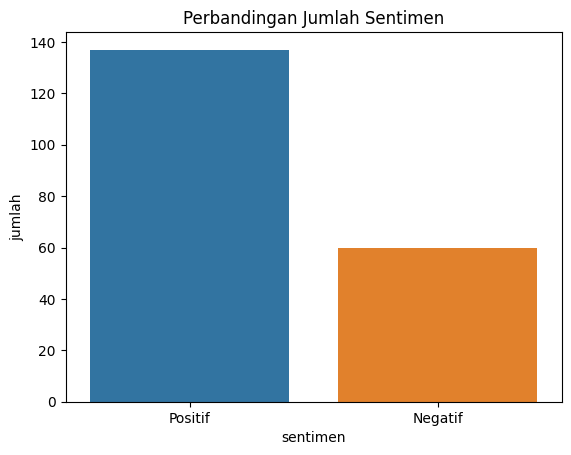

In [ ]:
# membuat dataframe untuk data jumlah sentimen
df1 = pd.DataFrame({'sentimen': ['Positif', 'Negatif'],
                   'jumlah': [jumlah_positif, jumlah_negatif]})

# membuat grafik bar menggunakan seaborn
sns.barplot(x='sentimen', y='jumlah', data=df1)

# menambahkan judul pada grafik
plt.title('Perbandingan Jumlah Sentimen')

# menampilkan grafik
plt.show()


In [ ]:
# Membuat Grafik persentase
fig = px.pie(df, names='Sentimen', title = 'Persentase Label Sentiment')
fig.update_layout(title={'x':0.5, 'y':0.95, 'xanchor':'center', 'yanchor':'top'})
fig.show()

### Frekuensi Kata

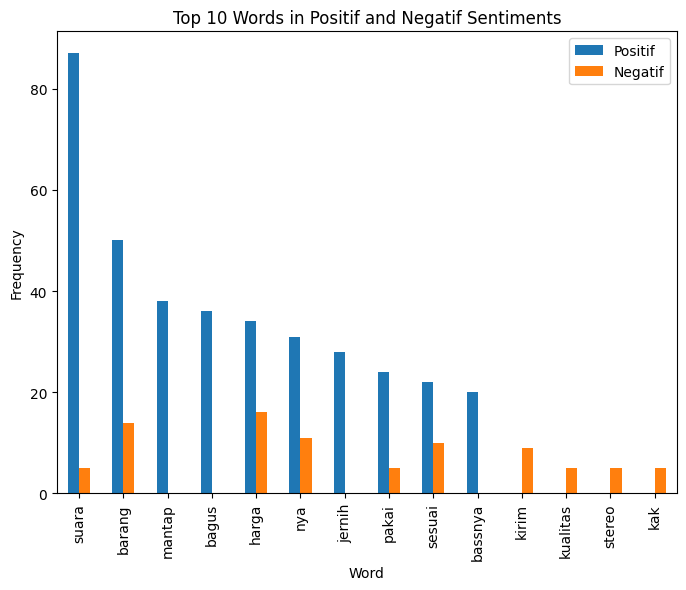

In [ ]:
# tokenisasi dan hitung frekuensi kata pada masing-masing sentimen
pos_words = word_tokenize(' '.join(df[df['Sentimen'] == 'Positif']['Stemming']).lower())
pos_freq = Counter(pos_words).most_common(10)
neg_words = word_tokenize(' '.join(df[df['Sentimen'] == 'Negatif']['Stemming']).lower())
neg_freq = Counter(neg_words).most_common(10)

# Tampilkan 10 data teratas
pos_freq
neg_freq

# buat dataframe untuk frekuensi kata pada masing-masing sentimen
df_freq = pd.DataFrame({'Positif': dict(pos_freq), 'Negatif': dict(neg_freq)})
df_freq.index.name = 'word'
df_freq.reset_index(inplace=True)

# plot bar chart
fig, ax = plt.subplots(figsize=(8, 6))
df_freq.plot(kind='bar', x='word', ax=ax)
ax.set_title('Top 10 Words in Positif and Negatif Sentiments')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
# Tampilkan 10 data teratas untuk sentimen positif
pd.DataFrame(pos_freq)

,0,1
0,suara,87
1,barang,50
2,mantap,38
3,bagus,36
4,harga,34
5,nya,31
6,jernih,28
7,pakai,24
8,sesuai,22
9,bassnya,20


In [ ]:
# Tampilkan 10 data teratas untuk sentimen negatif
pd.DataFrame(neg_freq)

,0,1
0,harga,16
1,barang,14
2,nya,11
3,sesuai,10
4,kirim,9
5,suara,5
6,kualitas,5
7,stereo,5
8,pakai,5
9,kak,5


### Dataset Spliting

In [ ]:
# Training test split
X = df.Stemming
y = df.Sentimen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Data Testing 30%
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((137,), (60,), (137,), (60,))

### Training Model Algoritma Naive Bayes

In [ ]:
# Create Model Naive Bayes Menggunakan Pipeline
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', ComplementNB())
])

pipeline.fit(X_train, y_train)

# evaluasi model
print("Train score: {:.2f}".format(pipeline.score(X_train, y_train)))
print("Test score: {:.2f}".format(pipeline.score(X_test, y_test)))

Train score: 0.96
Test score: 0.70


### Prediksi Model Naive Bayes dari data X_test

In [ ]:
naive_predict = pipeline.predict(X_test)
naive_predict

array(['Positif', 'Negatif', 'Positif', 'Positif', 'Positif', 'Positif',
       'Positif', 'Negatif', 'Positif', 'Negatif', 'Negatif', 'Negatif',
       'Positif', 'Negatif', 'Positif', 'Positif', 'Positif', 'Negatif',
       'Positif', 'Negatif', 'Negatif', 'Positif', 'Positif', 'Positif',
       'Positif', 'Positif', 'Negatif', 'Negatif', 'Positif', 'Negatif',
       'Negatif', 'Negatif', 'Positif', 'Positif', 'Positif', 'Negatif',
       'Negatif', 'Positif', 'Positif', 'Positif', 'Positif', 'Positif',
       'Positif', 'Negatif', 'Positif', 'Positif', 'Negatif', 'Positif',
       'Positif', 'Positif', 'Positif', 'Positif', 'Negatif', 'Positif',
       'Positif', 'Negatif', 'Positif', 'Positif', 'Positif', 'Positif'],
      dtype='<U7')

### Confusion Matriks dari Naive Bayes

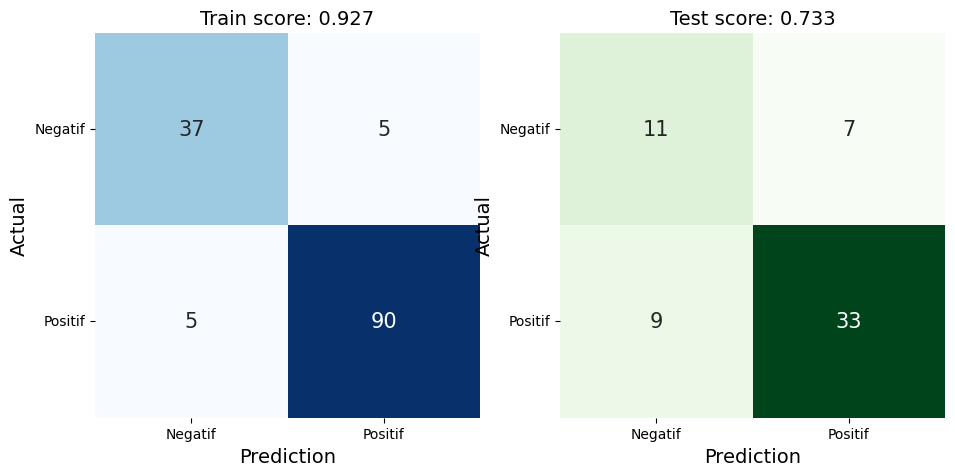

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, pipeline)

### Classification Report dari Naive Bayes

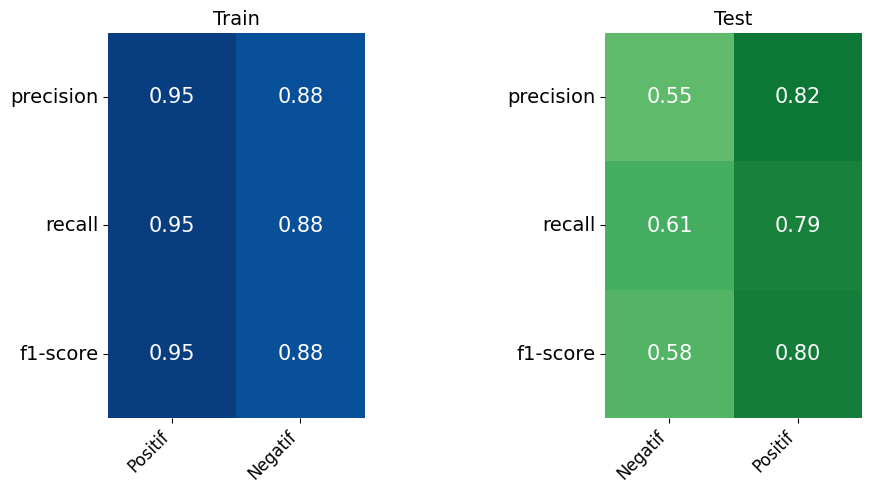

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, pipeline)

### Performance dari Naive Bayes

In [ ]:
print('Hasil Precision: %.3f' % precision_score(y_test, naive_predict, average='weighted'))
print('Hasil Recall: %.3f' % recall_score(y_test, naive_predict, average='weighted'))
print('Hasil Akurasi: %.3f' % accuracy_score(y_test, naive_predict))
print('Hasil F1-Score: %.3f' % f1_score(y_test, naive_predict, average='weighted'))

Hasil Precision: 0.742
Hasil Recall: 0.733
Hasil Akurasi: 0.733
Hasil F1-Score: 0.737


### Prediksi teks dari Naive Bayes

In [ ]:
pred_data = ['kotor']
pred = pipeline.predict(pred_data)
pred

array(['Negatif'], dtype='<U7')

### Klasifikasi dengan KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Definisikan parameter grid untuk KNN
params_knn = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 19],  # Anda bisa menyesuaikan jumlah tetangga
    'knn__weights': ['uniform', 'distance']
}

model_knn = GridSearchCV(pipeline_knn, param_grid=params_knn, cv=10, n_jobs=-1, verbose=1)
model_knn.fit(X_train, y_train)

# Evaluasi model KNN
print("Best parameters for KNN: {}".format(model_knn.best_params_))
print("Best cross-validation score for KNN: {:.2f}".format(model_knn.best_score_))
print("Train score for KNN: {:.2f}".format(model_knn.score(X_train, y_train)))
print("Test score for KNN: {:.2f}".format(model_knn.score(X_test, y_test)))


Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters for KNN: {'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'tfidf__ngram_range': (1, 1)}
Best cross-validation score for KNN: 0.75
Train score for KNN: 0.82
Test score for KNN: 0.70


### Confusion Matriks dari KNN

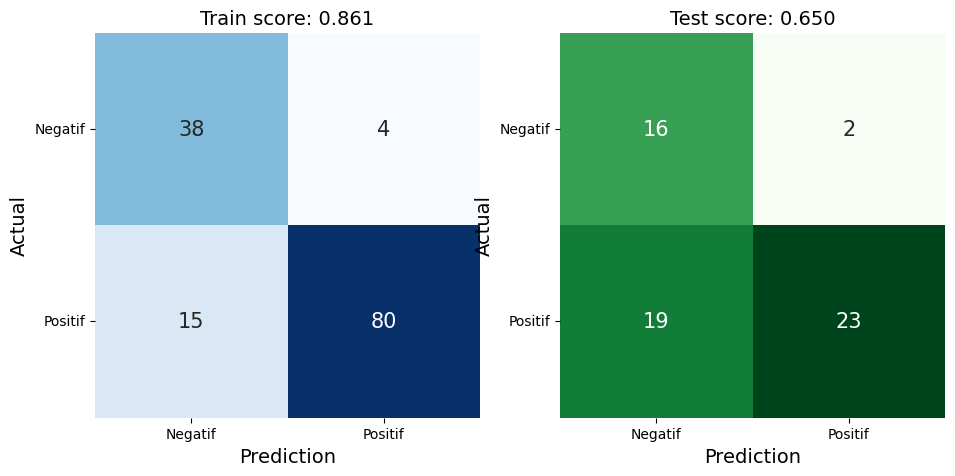

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test,model_knn)

### Classification Report dari KNN

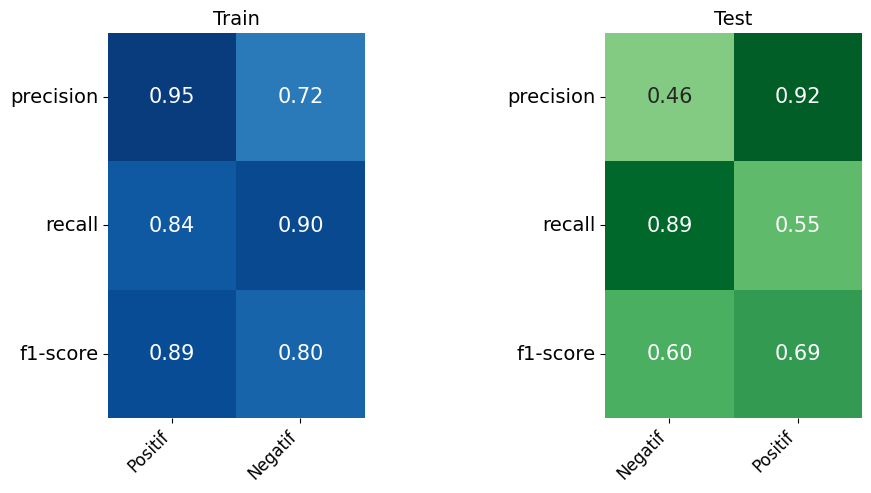

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model_knn)

### KNN prediksi dari data X_Test

In [ ]:
knn_predict = model_knn.predict(X_test)
knn_predict

array(['Negatif', 'Negatif', 'Positif', 'Positif', 'Negatif', 'Negatif',
       'Positif', 'Negatif', 'Negatif', 'Negatif', 'Negatif', 'Negatif',
       'Positif', 'Negatif', 'Positif', 'Negatif', 'Positif', 'Negatif',
       'Positif', 'Negatif', 'Positif', 'Positif', 'Positif', 'Negatif',
       'Positif', 'Positif', 'Negatif', 'Negatif', 'Negatif', 'Negatif',
       'Negatif', 'Negatif', 'Positif', 'Positif', 'Negatif', 'Negatif',
       'Negatif', 'Positif', 'Negatif', 'Positif', 'Negatif', 'Positif',
       'Negatif', 'Negatif', 'Positif', 'Negatif', 'Negatif', 'Negatif',
       'Negatif', 'Positif', 'Positif', 'Positif', 'Negatif', 'Positif',
       'Positif', 'Negatif', 'Positif', 'Negatif', 'Positif', 'Negatif'],
      dtype=object)

### Performance dari KNN

In [ ]:
print('Hasil Precision: %.3f' % precision_score(y_test, knn_predict, average='weighted'))
print('Hasil Recall: %.3f' % recall_score(y_test, knn_predict, average='weighted'))
print('Hasil Akurasi: %.3f' % accuracy_score(y_test, knn_predict))
print('Hasil F1-Score: %.3f' % f1_score(y_test, knn_predict, average='weighted'))

Hasil Precision: 0.781
Hasil Recall: 0.650
Hasil Akurasi: 0.650
Hasil F1-Score: 0.662


### Prediksi Model KNN

In [ ]:
pred_data1 = ['bagus']
pred_new = model_knn.predict(pred_data1)
pred_new

array(['Positif'], dtype=object)